Testing code for validating the base policy

In [1]:
import torch
import torch.nn as nn  # noqa: F401
import numpy as np
from tqdm import tqdm

import safety_gymnasium

from rl_vcf.rl.algos.sac.core import MLPActorCritic
from rl_vcf.rl.utils.make_env import make_env_safety
from rl_vcf.rl.utils.get_actor_structure import get_actor_structure

In [2]:
seed = 0
device = "cuda"
num_envs = 8
envs = safety_gymnasium.vector.SafetySyncVectorEnv(
    [
        make_env_safety(
            "SafetyPointReachAvoidReset1-v0",
            i,
            seed + i,
            False,
            5,
            False,
        )
        for i in range(num_envs)
    ]
)

In [3]:
# Load state dict
loaded_state_dict = torch.load(
    "../torch/test_policy.pt", weights_only=True, map_location=device
)

# Construct agent from state dict
loaded_hidden_sizes, loaded_activation = get_actor_structure(
    loaded_state_dict, envs.single_observation_space, envs.single_action_space
)

agent = MLPActorCritic(
    envs.single_observation_space,
    envs.single_action_space,
    loaded_hidden_sizes,
    eval("nn." + loaded_activation + "()"),
)
agent.pi.load_state_dict(loaded_state_dict, strict=True)
agent.to(device)

# Prevent storing gradients
for p in agent.parameters():
    p.requires_grad = False

In [89]:
max_episode_length = 1000
N = 1000
# Initialize scenario information database
task_success_data = np.full((N, max_episode_length + 1), False, dtype=bool)

# Track scenario number and the time step for that scenario
scenario_pointers = np.zeros((num_envs, 2), dtype=int)
scenario_pointers[:, 0] = np.arange(num_envs, dtype=int)
print(scenario_pointers)

# This is where task success flags for the active scenarios are found
goal_achieved = np.full(num_envs, False, dtype=bool)
# This is where the done flags are found
done = np.full(num_envs, False, dtype=bool)

[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]
 [6 0]
 [7 0]]


In [90]:
print(scenario_pointers.shape[0])

8


In [91]:
print(scenario_pointers[2][1])

0


In [92]:
print(task_success_data[1][999:])

[False False]


In [93]:
print(max(scenario_pointers[:, 0]))

7


In [94]:
max_episode_length = 1000
N = 1000
# Initialize scenario information database
task_success_data = np.full((N, max_episode_length + 1), False, dtype=bool)

# Track scenario number and the time step for that scenario
scenario_pointers = np.zeros((num_envs, 2), dtype=int)
scenario_pointers[:, 0] = np.arange(num_envs, dtype=int)
print(scenario_pointers)

# This is where task success flags for the active scenarios are found
goal_achieved = np.full(num_envs, False, dtype=bool)
# This is where the done flags are found
done = np.full(num_envs, False, dtype=bool)

# ---
# TESTING:
# Randomly generate task success flags
p_goal = 0.01
# Randomly generate done flags (term | trunc)
p_done = 0.0002
# ---

# VALIDATION LOOP:

# Instantiate progress bar
pbar = tqdm(total=N)
# While we haven't collected all required scenarios
while any(scenario_pointers[:, 0] < N):
    # TESTING: environment step (and goal achieved reasoning) will go here

    # For each active scenario, check task status
    for p_idx in range(num_envs):
        # If the scenario is to be collected
        if scenario_pointers[p_idx][0] < N:
            # ---
            # TESTING:
            # Randomly generate done flag (represents constraint violation)
            done[p_idx] = np.random.rand() < p_done
            # Randomly generate goal flag (represents goal achievement)
            goal_achieved[p_idx] = np.random.rand() < p_goal
            # If the goal was achieved, mark the task as done
            done[p_idx] = done[p_idx] | goal_achieved[p_idx]
            # If the scenario has reached the max episode length, mark as done
            if scenario_pointers[p_idx][1] == max_episode_length:
                done[p_idx] = True
            # ---
            # If the task is done:
            if done[p_idx]:
                # If the task is done because the goal was achieved, mark the task as successful
                if goal_achieved[p_idx]:
                    # On scenario task success, mask current and future time steps as task success
                    # (Assumes reach-avoid task with no consideration of failure after success)
                    task_success_data[scenario_pointers[p_idx][0]][
                        scenario_pointers[p_idx][1] :
                    ] = True
                # else, the task was not successful (violated a constraint, or ran out of time)
                # The scenario pointer now tracks next scenario
                scenario_pointers[p_idx][0] = np.max(scenario_pointers[:, 0]) + 1
                # Reset the time step for the next scenario
                scenario_pointers[p_idx][1] = 0
                # Update progress bar
                pbar.update(1)
            else:
                # If scenario is ongoing, increment pointer time step
                scenario_pointers[p_idx][1] += 1

# Close progress bar
pbar.close()

task_success_count_per_timestep = task_success_data.sum(axis=0)
print(task_success_count_per_timestep)

[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]
 [6 0]
 [7 0]]


100%|██████████| 1000/1000 [00:00<00:00, 8773.80it/s]

[  9  19  23 ... 981 981 981]


In [95]:
print(scenario_pointers)

[[1005    0]
 [1003    0]
 [1000    0]
 [1004    0]
 [1007    0]
 [1006    0]
 [1001    0]
 [1002    0]]


In [96]:
print(task_success_data.shape)

(1000, 1001)


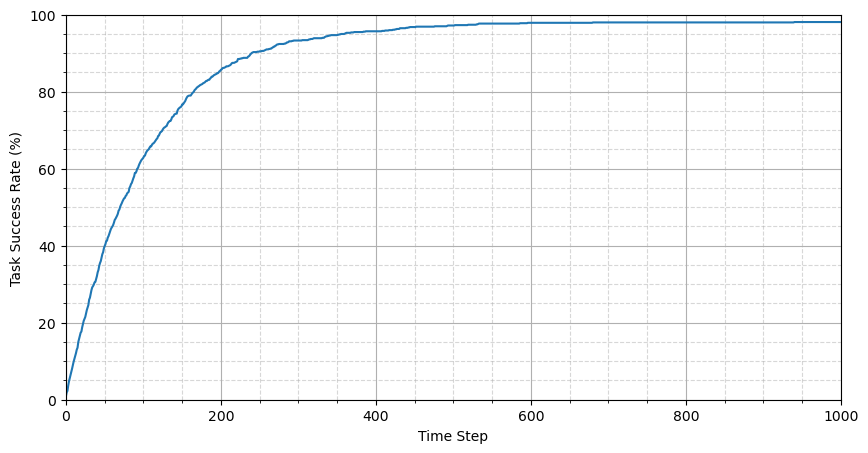

In [97]:
import matplotlib.pyplot as plt

# Plot task success rate
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(task_success_count_per_timestep / N * 100)
ax.set_xlim([0, max_episode_length])
ax.set_ylim([0, 100])
ax.set_xlabel("Time Step")
ax.set_ylabel("Task Success Rate (%)")
ax.minorticks_on()
ax.grid(which="major")
ax.grid(which="minor", linestyle="--", alpha=0.5)

In [ ]:
import math
from concurrent.futures import ProcessPoolExecutor
from typing import Container


def estimate_epsilon(
    conf: float, N: int, k: int, it_max: int = 100, tol: float | None = None
) -> float:
    """
    Numerically estimate epsilon for a given confidence level using a divide-and-conquer approach.

    Note that the function returns an upper bound on epsilon.
    """
    # TODO: The binomial coefficient explodes when N is large (somewhere 10000 > N > 1000)
    # as k increases, making numerical estimation impossible.
    # For cases where N is large and k is not small, we will need to settle for less tight bound
    # that is still computationally feasible.

    # Compute beta
    beta = 1 - conf

    # Initialize epsilon bounds
    eps_lower = 0.0
    eps_upper = 1.0

    # Initialize iteration counter
    it = 0

    # Precompute binomial coefficients
    binom_coeffs = np.array([math.comb(N, i) for i in range(k + 1)])

    # Precompute indices
    indices = np.arange(k + 1)

    while it < it_max:
        # Increment iteration counter
        it += 1

        # Trial epsilon is midway between current bounds
        eps_trial = (eps_lower + eps_upper) / 2

        # Compute beta for trial epsilon using vectorized operations
        eps_powers = eps_trial**indices
        one_minus_eps_powers = (1 - eps_trial) ** (N - indices)
        beta_trial = np.sum(binom_coeffs * eps_powers * one_minus_eps_powers)

        # If trial beta is lower than target beta, we set the upper bound to the trial epsilon
        if beta_trial <= beta:
            eps_upper = eps_trial
        # Otherwise, we set the lower bound to the trial epsilon
        else:
            eps_lower = eps_trial

        # Early stopping condition
        if tol is not None:
            if eps_upper - eps_lower <= tol:
                break

    return eps_upper


def estimate_epsilon_parallel(
    conf: float,
    N: int,
    k_values: Container[int],
    it_max: int = 100,
    tol: float | None = None,
) -> list[float]:
    """
    Parallelized epsilon estimation across different values of k using multiprocessing.
    """
    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(estimate_epsilon, conf, N, k, it_max, tol) for k in k_values
        ]
        results = [future.result() for future in futures]
    return results

In [99]:
# Test numerical result for epsilon

# Compute k for each timestep
ks = N - task_success_count_per_timestep

conf = 0.99
k = 3

epsilon = estimate_epsilon(conf, N, k, it_max=100, tol=1e-5)
print(epsilon)

test_beta = sum(
    math.comb(N, i) * (epsilon**i) * ((1 - epsilon) ** (N - i)) for i in range(k + 1)
)
test_conf = 1 - test_beta
print(test_conf)

0.01001739501953125
0.9900560675132372


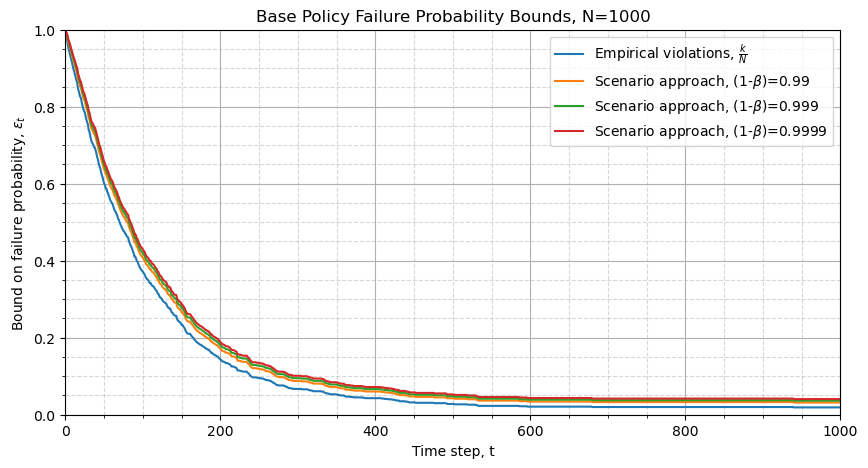

In [100]:
# Plot different methods for computing epsilon
fig, ax = plt.subplots(figsize=(10, 5))


emp_str = r"Empirical violations, $\frac{k}{N}$"
ax.plot(
    (ks / N),
    label=emp_str,
)
confs = [0.99, 0.999, 0.9999]
for conf in confs:
    # Compute bound on failure probability at each time step
    unique_ks = np.unique(ks)
    epsilon_dict = dict(
        zip(unique_ks, estimate_epsilon_parallel(conf, N, unique_ks, tol=1e-5))
    )
    epsilons = np.array([epsilon_dict[k] for k in ks])
    scen_str = r"Scenario approach, (1-$\beta$)={f}".format(f=conf)
    ax.plot(epsilons, label=scen_str)
ax.set_xlim([0, max_episode_length])
ax.set_ylim([0, 1])
ax.set_xlabel("Time step, t")
ax.set_ylabel("Bound on failure probability, $\epsilon_{t}$")
ax.minorticks_on()
ax.grid(which="major")
ax.grid(which="minor", linestyle="--", alpha=0.5)
ax.legend()
title_str = f"Base Policy Failure Probability Bounds, N={N}"
ax.title.set_text(title_str)

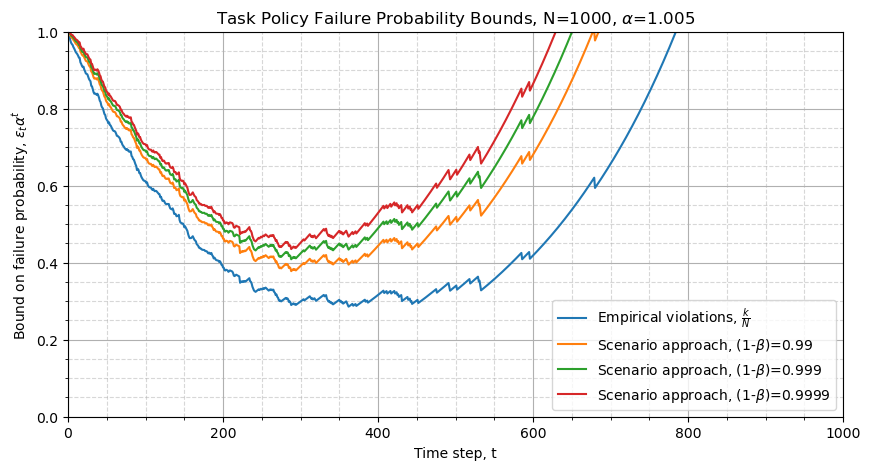

In [101]:
alpha = 1.005

# Plot different methods for computing epsilon
fig, ax = plt.subplots(figsize=(10, 5))

indices = np.arange(max_episode_length + 1)
alphas = alpha**indices

emp_str = r"Empirical violations, $\frac{k}{N}$"
epsilons = ks / N
epsilons = np.minimum(epsilons * alphas, 1.0)
ax.plot(epsilons, label=emp_str)
confs = [0.99, 0.999, 0.9999]
for conf in confs:
    # Compute bound on failure probability at each time step
    unique_ks = np.unique(ks)
    epsilon_dict = dict(
        zip(unique_ks, estimate_epsilon_parallel(conf, N, unique_ks, tol=1e-5))
    )
    epsilons = np.array([epsilon_dict[k] for k in ks])
    epsilons = np.minimum(epsilons * alphas, 1.0)
    scen_str = r"Scenario approach, (1-$\beta$)={f}".format(f=conf)
    ax.plot(epsilons, label=scen_str)
ax.set_xlim([0, max_episode_length])
ax.set_ylim([0, 1])
ax.set_xlabel("Time step, t")
ax.set_ylabel("Bound on failure probability, $\epsilon_{t} \\alpha^{t}$")
ax.minorticks_on()
ax.grid(which="major")
ax.grid(which="minor", linestyle="--", alpha=0.5)
ax.legend()
title_str = f"Task Policy Failure Probability Bounds, N={N}, $\\alpha$={alpha}"
ax.title.set_text(title_str)

In [ ]:
# obs, info = envs.reset(seed=[seed + i for i in range(num_envs)])

# with torch.no_grad():  # no gradient needed for testing
#     for global_step in tqdm(range(5)):
#         act = torch.Tensor(
#             np.array([envs.single_action_space.sample() for _ in range(num_envs)])
#         )
#         # act, _ = agent.pi.forward(torch.Tensor(obs).to(device), with_log_prob=False)
#         next_obs, rew, cost, term, trunc, info = envs.step(act.detach().cpu().numpy())
#         obs = next_obs
# print(info)

In [23]:
obs, info = envs.reset(seed=[seed + i for i in range(num_envs)])
print(info)
next_obs, rew, cost, term, trunc, info = envs.step(act.detach().cpu().numpy())
print(info)

{}
{'cost_hazards': array([0., 0., 0., 0.]), '_cost_hazards': array([ True,  True,  True,  True]), 'cost_sum': array([0., 0., 0., 0.]), '_cost_sum': array([ True,  True,  True,  True]), 'constraint_violated': array([False, False, False, False]), '_constraint_violated': array([ True,  True,  True,  True]), 'goal_met': array([False, False, False, False]), '_goal_met': array([ True,  True,  True,  True])}
